In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.append('../lib/')
from utils import *
from analysis import * 
from datetime import timedelta
import pywt

In [2]:
df = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = df.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric['Seconds'] = (Electric.Date - Electric.Date[0]).dt.total_seconds()
Electric.set_index('Date', inplace=True)

In [3]:
Electric

,Hour,Minute,Load,Seconds
Date,,,,
2008-01-01 00:15:00,0,15,15938.8,0.0
2008-01-01 00:30:00,0,30,15770.4,900.0
2008-01-01 00:45:00,0,45,15766.3,1800.0
2008-01-01 01:00:00,1,0,15415.2,2700.0
2008-01-01 01:15:00,1,15,15351.8,3600.0
...,...,...,...,...
2016-12-31 23:00:00,23,0,15952.7,284078700.0
2016-12-31 23:15:00,23,15,15865.3,284079600.0
2016-12-31 23:30:00,23,30,15693.5,284080500.0


In [93]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(Electric.Load.to_numpy())

# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

Estimated Gaussian noise standard deviation = 97.80001008282466


In [86]:
im_bayes = denoise_wavelet(Electric.Load.to_numpy(), method='BayesShrink', mode='soft',
                           rescale_sigma=True)
im_visushrink = denoise_wavelet(Electric.Load.to_numpy(), method='VisuShrink', mode='soft',
                                sigma=sigma_est, rescale_sigma=True)

# VisuShrink is designed to eliminate noise with high probability, but this
# results in a visually over-smooth appearance.  Repeat, specifying a reduction
# in the threshold by factors of 2 and 4.
im_visushrink2 = denoise_wavelet(Electric.Load.to_numpy(), method='VisuShrink', mode='soft',
                                 sigma=sigma_est/2, rescale_sigma=True)
im_visushrink4 = denoise_wavelet(Electric.Load.to_numpy(), method='VisuShrink', mode='soft',
                                 sigma=sigma_est/4, rescale_sigma=True)

In [91]:
def doane_formula(data: np.array) -> int:
    """
    Compute the optimal bin width with the Doane's formula:
    k = 1 + log_2(n) + log_2(n) * (1 + |g_1| / sigma_{g_1})
    where g_1 is the 3rd-moment-skewness and 
    sigma_{g_1} = sqrt{6 * (n - 2) / [(n + 1)(n + 3)]}
    Args:
        data (np.array): data whose bin is being sought
    Returns:
        int: optimal bin width
    """
    import scipy.stats as st
    import math
    
    N = len(data)
    skewness = st.skew(data)
    sigma_g1 = math.sqrt((6 * (N - 2)) / ((N + 1) * (N + 3)))
    num_bins = 1 + math.log(N, 2) + math.log(1 + abs(skewness) / sigma_g1, 2)
    return round(num_bins)


doane_formula(Electric.Load.to_numpy() - im_visushrink)

20

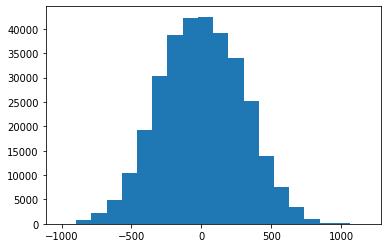

In [92]:
plt.hist(Electric.Load.to_numpy() - im_visushrink, bins=20)
plt.show()

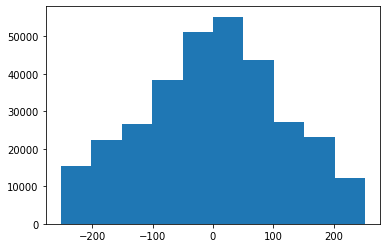

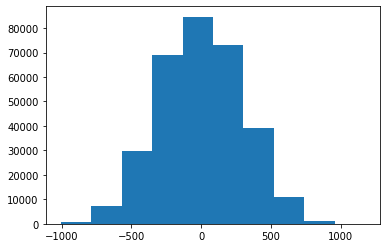

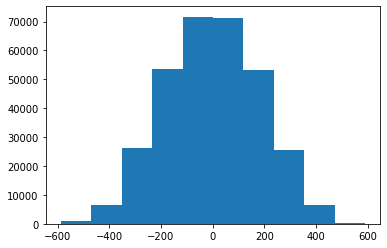

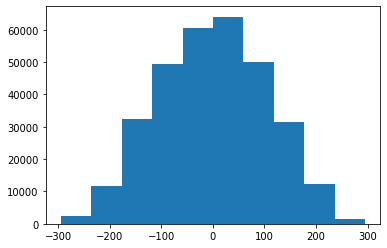

(0.02384146692868304, 0.0009999999999998899) -0.5500131500740264 (378.6406180820777, 0.0)
(0.013869986586794503, 0.0009999999999998899) -0.3027097967964374 (118.08557307696901, 0.0)
(0.01500634103545273, 0.0009999999999998899) -0.4413465794466003 (185.5533939874149, 0.0)
(0.018490167868028567, 0.0009999999999998899) -0.5737650677897359 (330.78494377277093, 0.0)


In [87]:
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from scipy.stats import kurtosis


plt.hist(Electric.Load.to_numpy() - im_visushrink)
plt.show()


plt.hist(Electric.Load.to_numpy() - im_visushrink2)
plt.show()

plt.hist(Electric.Load.to_numpy() - im_visushrink4)
plt.show()


print(kstest_normal(Electric.Load.to_numpy() - im_visushrink), kurtosis(Electric.Load.to_numpy() - im_visushrink), normal_ad(Electric.Load.to_numpy() - im_visushrink))
print(kstest_normal(Electric.Load.to_numpy() - im_visushrink2), kurtosis(Electric.Load.to_numpy() - im_visushrink2), normal_ad(Electric.Load.to_numpy() - im_visushrink2))
print(kstest_normal(Electric.Load.to_numpy() - im_visushrink4), kurtosis(Electric.Load.to_numpy() - im_visushrink4), normal_ad(Electric.Load.to_numpy() - im_visushrink4))

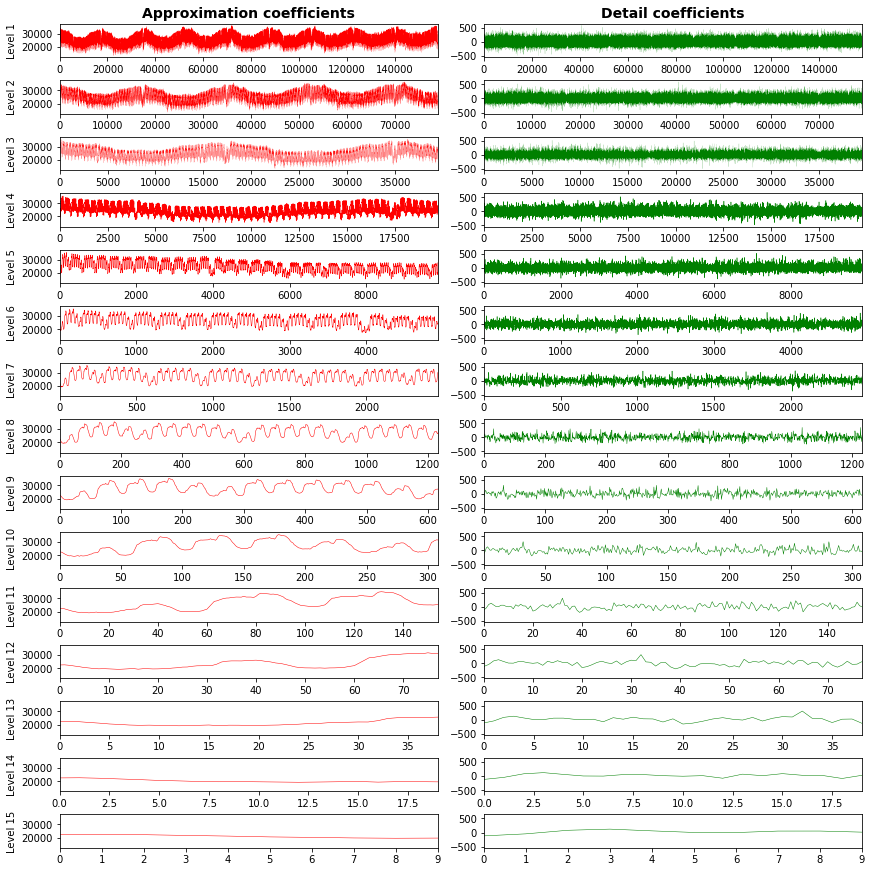

In [7]:
x = Electric.Load.to_numpy()
wavelet_coeffs_plot(x, waveletname='sym4', figsize=(12, 12));

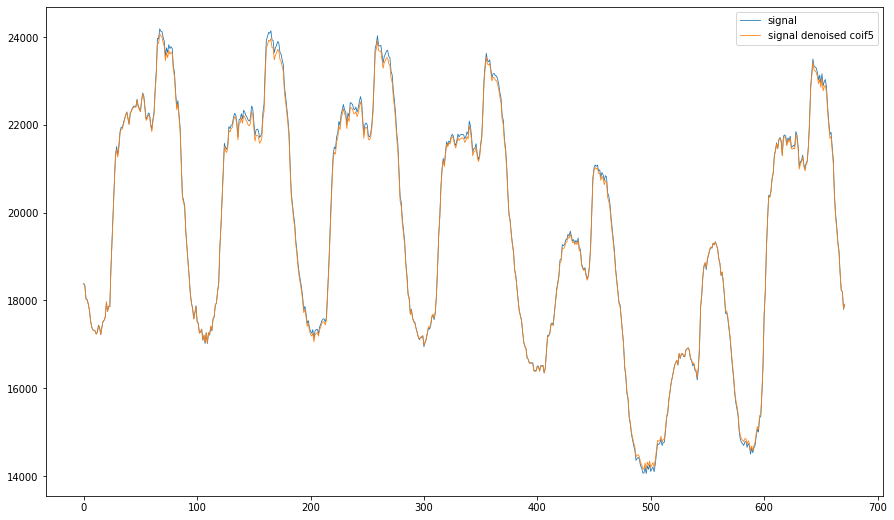

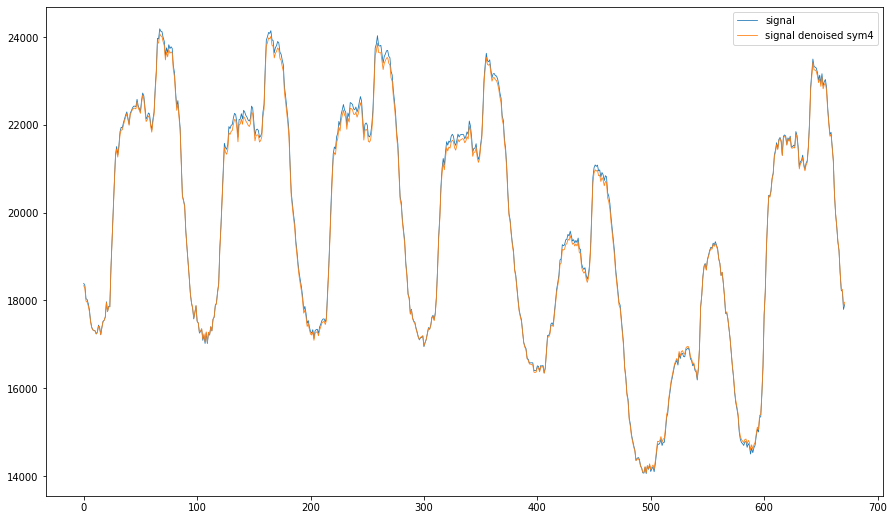

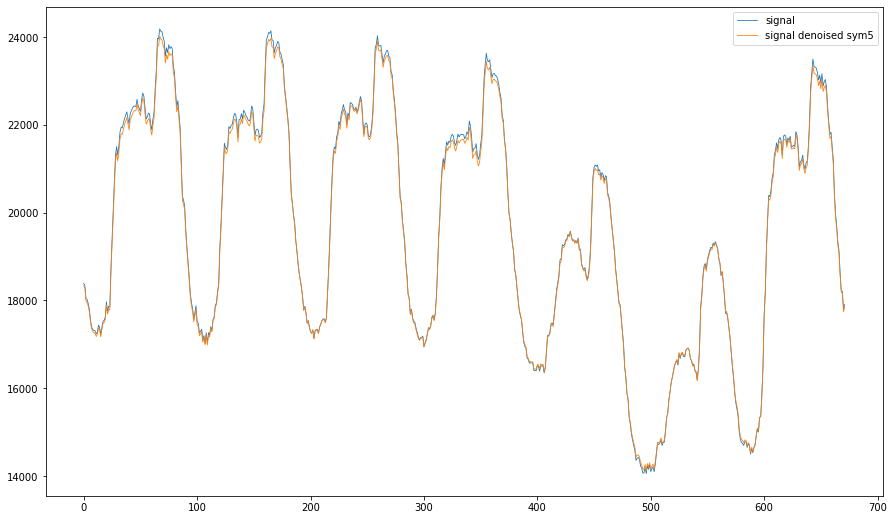

In [42]:
wavelets = ['coif5', 'sym4', 'sym5']

for wave in wavelets:
    plt.figure(figsize=(15, 9))
    Load_denoised = wavelet_filter(Electric.Load.to_numpy(), wavelet=wave, threshold=0.01)
    plt.plot(Electric.Load.to_numpy()[96*7:96*7*2], lw=0.8, label='signal')
    plt.plot(Load_denoised[96*7:96*7*2], lw=0.8, label=f'signal denoised {wave}')
    plt.legend()
    plt.show()



In [57]:
tests = []
thresholds = np.arange(0.001, 0.09, 0.001)
wavelets = ['coif5', 'sym4', 'sym5']

for wave in wavelets:
    for thr in thresholds:
        Load_denoised = wavelet_filter(Electric.Load.to_numpy(), wavelet=wave, threshold=thr)
        x = Electric.Load.to_numpy() - Load_denoised
        tests.append(kurtosis(x))

In [80]:
thresholds = np.arange(0.001, 0.09, 0.001)


max(tests)

-0.30560119203916436

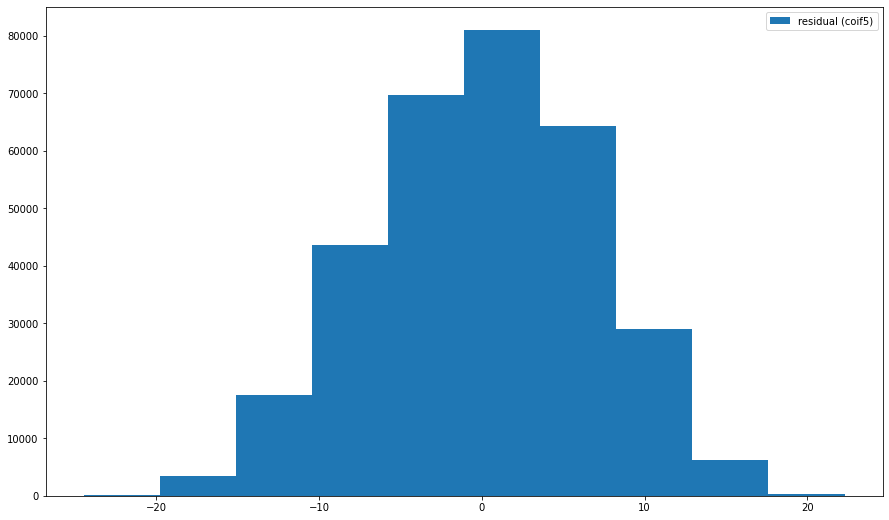

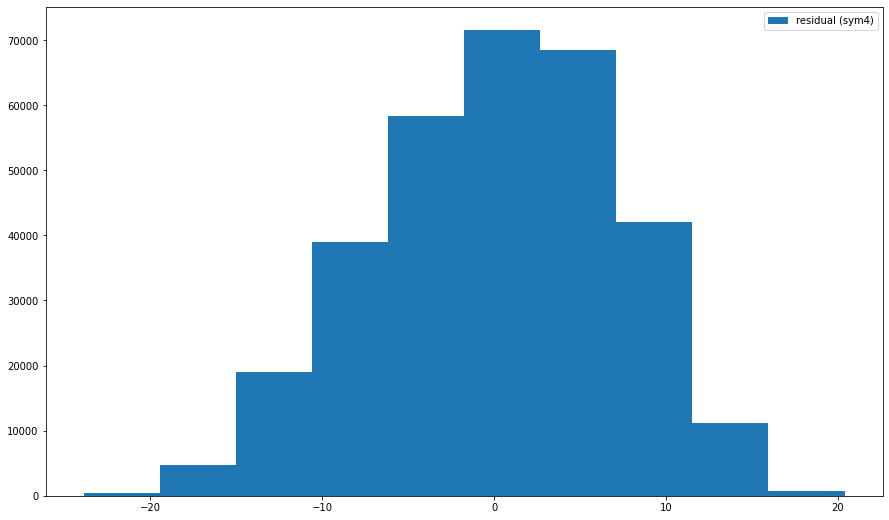

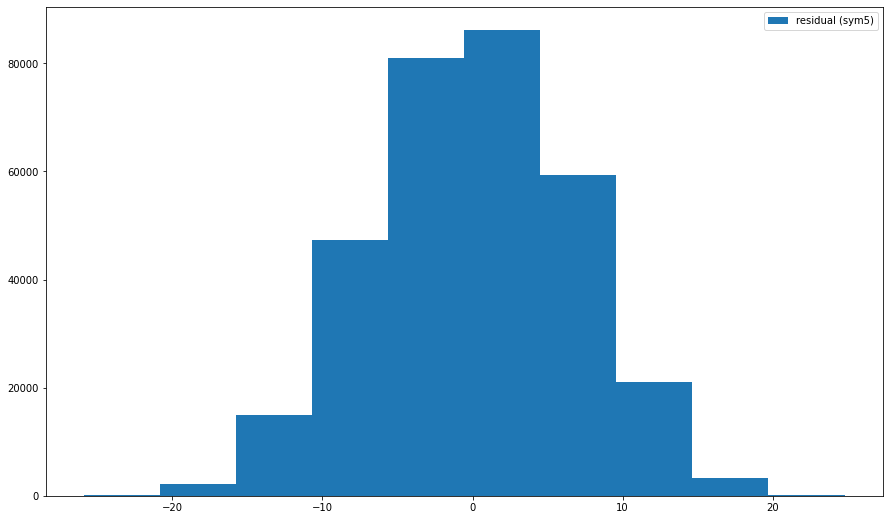

In [65]:
wavelets = ['coif5', 'sym4', 'sym5']

for wave in wavelets:
    plt.figure(figsize=(15, 9))
    Load_denoised = wavelet_filter(Electric.Load.to_numpy(), wavelet=wave, threshold=0.01)
    plt.hist(Electric.Load.to_numpy() - Load_denoised, label=f'residual ({wave})')
    plt.legend()

maximum level is 13


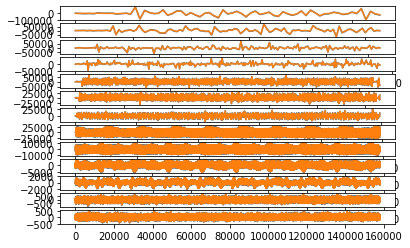

In [5]:
maxlev = pywt.dwt_max_level(len(Electric), 'coif5')
# maxlev = 6 # Override if desired
print("maximum level is " + str(maxlev))
threshold = 0.04 # Threshold for filtering

# Decompose into wavelet components, to the level selected:
coeffs = pywt.wavedec(Electric.Load.to_numpy(), 'coif5', level=maxlev)

#cA = pywt.threshold(cA, threshold*max(cA))
plt.figure()
for i in range(1, len(coeffs)):
    plt.subplot(maxlev, 1, i)
    plt.plot(coeffs[i])
    coeffs[i] = pywt.threshold(coeffs[i], mode='soft', 
                               value=threshold*max(coeffs[i]))
    plt.plot(coeffs[i])

In [5]:
datarec = pywt.waverec(coeffs, 'sym4')

In [22]:
params = latex_settings()
mpl.rcParams.update(params)

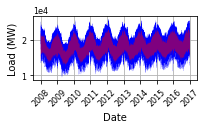

In [26]:
datarec = wavelet_filter(data=Electric.Load.to_numpy(), wavelet='coif5', threshold=0.30)

plt.plot(Electric.Load, 'b', lw=0.1, label='Raw signal')
plt.plot(Electric.index, datarec, 'r', alpha=0.5, lw=0.1,
         label='De-noised signal')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.xticks(rotation=45)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#leg = plt.legend()

#for lh in leg.legendHandles: 
 #   lh.set_alpha(1)
  #§  lh.set_linewidth(1)
plt.grid()
plt.tight_layout()
plt.savefig('./Images/Wavelet_denoise', dpi=800)

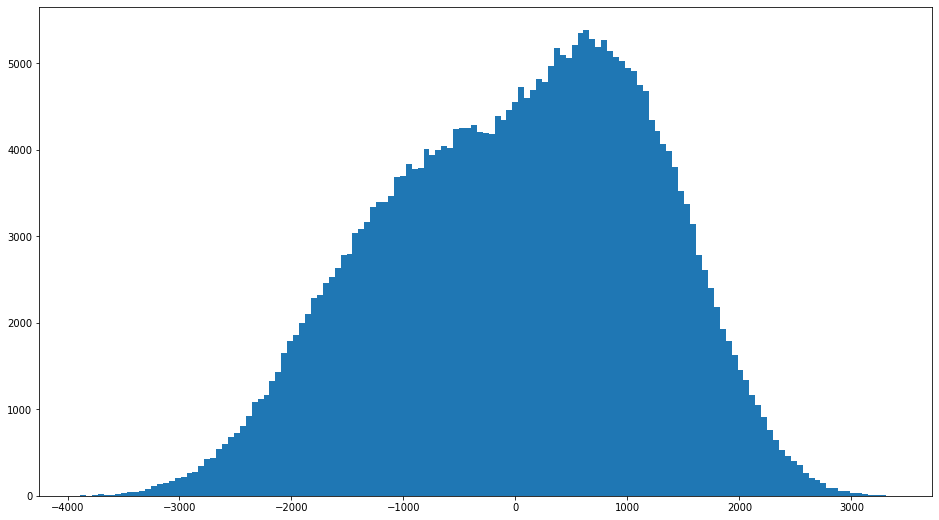

In [16]:
plt.hist(Electric.Load.to_numpy() - datarec, bins='auto');